# Weather Classifcation 


**Credit: [AITS Cainvas Community](https://discord.gg/x6xn39u)**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/weather.gif)

*Photo by [Sergey Galtsev](https://dribbble.com/shots/10995591-Animated-Icons) on [Dribbble](https://dribbble.com)*

Image tagging helps in selecting images based on content, especially useful in search engines and other similar applications.
Here, we tag images based on the weather of the scene. There are two classes - cloudy, sunny.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import layers, optimizers, models, preprocessing, losses, callbacks
import os
import random
from PIL import Image
import tensorflow as tf
import keras

# Dataset

> "Two-class Weather Classification"
Cewu Lu, Di Lin, Jiaya Jia, Chi-Keung Tang
IEEE Conference on Computer Vision and Pattern Recognition (CVPR), 2014

[On Kaggle](https://www.kaggle.com/polavr/twoclass-weather-classification) by [Paula](https://www.kaggle.com/polavr)

In [2]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/weather.zip
 
!unzip -qo weather.zip

!rm weather.zip

--2021-01-08 14:41:24--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/weather.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.72
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116150379 (111M) [application/zip]
Saving to: ‘weather.zip’

weather.zip         100%[===================>] 110.77M  91.2MB/s    in 1.2s    

2021-01-08 14:41:25 (91.2 MB/s) - ‘weather.zip’ saved [116150379/116150379]



In [3]:
# Loading the dataset

path = 'weather/'
input_shape = (256, 256, 3)    # default input shape while loading the images

batch = 64

# The train and test datasets
print("Train dataset")
train_ds = preprocessing.image_dataset_from_directory(path+'train', batch_size=batch, label_mode='binary')

print("Test dataset")
test_ds = preprocessing.image_dataset_from_directory(path+'test', batch_size=batch, label_mode='binary')


Train dataset
Found 10000 files belonging to 2 classes.
Test dataset
Found 253 files belonging to 2 classes.


In [4]:
# How many samples in each class

for t in ['train', 'test']:
    print('\n', t.upper())
    for x in os.listdir(path + t):
        print(x, ' - ', len(os.listdir(path + t + '/' + x)))


 TRAIN
sunny  -  5000
cloudy  -  5000

 TEST
sunny  -  153
cloudy  -  100


The train set is balanced while the test set is imbalanced. A confusion matrix can help in finding the accuracies.

In [5]:
# Looking into the class labels

class_names = train_ds.class_names

print("Train class names: ", train_ds.class_names)
print("Test class names: ", test_ds.class_names)

Train class names:  ['cloudy', 'sunny']
Test class names:  ['cloudy', 'sunny']


# Visualization

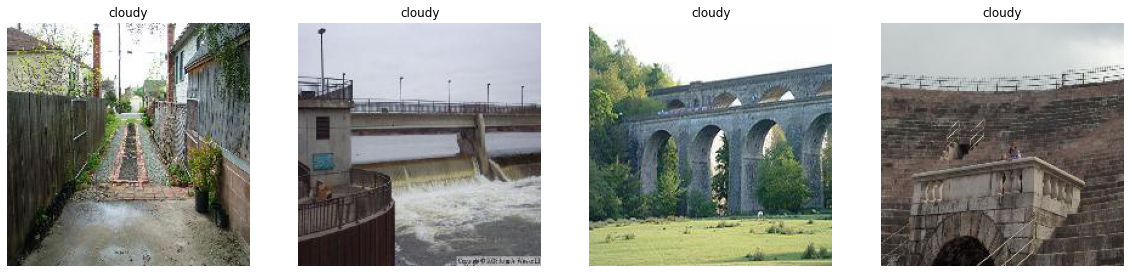

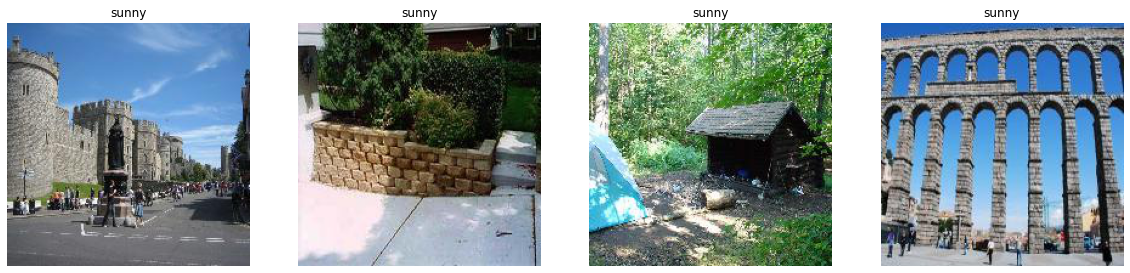

In [6]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(20, 20))

    filenames = os.listdir(path + 'train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(path +'train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

Feel free to load more images and see the various images in the dataset. 

It is important to note that the differences in the images are not very contrasting. In some cases, even humans may find it difficult to categorise them with high confidence.

# Preprocessing

## Normalization

In [7]:
# Normalizing the pixel values for faster convergence

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# The model

In [8]:
base_model = keras.applications.DenseNet121(weights='imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation = 'sigmoid')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

cb = [callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True)]

In [9]:
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.01), metrics=['accuracy'])

history = model.fit(train_ds, validation_data =  test_ds, epochs=32, callbacks = cb)

Epoch 1/32
157/157 [==============================] - 48s 305ms/step - loss: 0.5110 - accuracy: 0.7500 - val_loss: 0.6315 - val_accuracy: 0.6640
Epoch 2/32
157/157 [==============================] - 45s 288ms/step - loss: 0.3943 - accuracy: 0.8259 - val_loss: 0.4439 - val_accuracy: 0.7905
Epoch 3/32
157/157 [==============================] - 46s 291ms/step - loss: 0.3682 - accuracy: 0.8391 - val_loss: 0.6095 - val_accuracy: 0.7312
Epoch 4/32
157/157 [==============================] - 47s 297ms/step - loss: 0.3556 - accuracy: 0.8419 - val_loss: 0.6310 - val_accuracy: 0.7431
Epoch 5/32
157/157 [==============================] - 47s 303ms/step - loss: 0.3415 - accuracy: 0.8510 - val_loss: 0.6720 - val_accuracy: 0.7233
Epoch 6/32
157/157 [==============================] - 49s 310ms/step - loss: 0.3271 - accuracy: 0.8605 - val_loss: 0.8780 - val_accuracy: 0.6561
Epoch 7/32
157/157 [==============================] - 49s 315ms/step - loss: 0.3359 - accuracy: 0.8574 - val_loss: 0.3978 - val_ac

In [10]:
model.evaluate(test_ds)

4/4 [==============================] - 1s 193ms/step - loss: 0.3978 - accuracy: 0.8221


[0.39778465032577515, 0.8221343755722046]

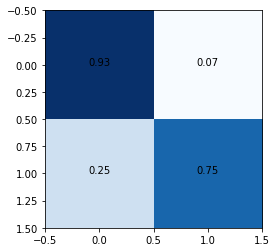

In [11]:
true_labels, predicted_labels = [], []

for x in test_ds.as_numpy_iterator():
    images, labels = x
    true_labels.extend(labels.flatten().astype('int'))
    output = (model.predict(images)>0.5).astype('int')
    predicted_labels.extend(output.flatten())
    

cm = confusion_matrix(true_labels, predicted_labels)
cm = cm.astype('int') / cm.sum(axis=1)[:, np.newaxis]

for i in range(cm.shape[1]):
    for j in range(cm.shape[0]):
        plt.text(j, i, format(cm[i, j], '.2f'), horizontalalignment="center", color="black")


plt.imshow(cm, cmap=plt.cm.Blues)

# Plotting the metrics

In [12]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.title(variable)

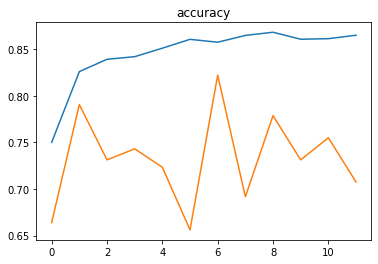

In [13]:
plot(history.history, "accuracy", 'val_accuracy')

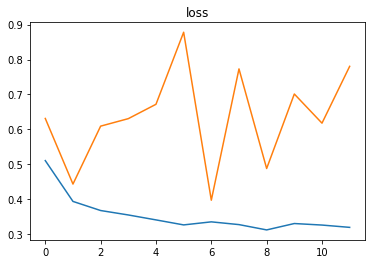

In [14]:
plot(history.history, "loss", "val_loss")

# Prediction

Predicted:  sunny ( 0.7369703 --> 1 )
True:  sunny


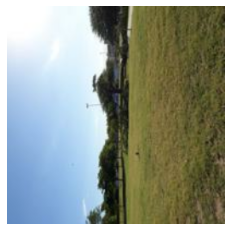

In [15]:
# pick random test data sample from one batch
x = random.randint(0, batch - 1)

for i in test_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (32, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))[0][0]    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = (output > 0.5).astype('int')
    print("Predicted: ", class_names[pred], '(', output, '-->', pred, ')')    # Picking the label from class_names base don the model output
    print("True: ", class_names[label[x][0].astype('int')])
    break

# deepC

In [16]:
model.save('weather.h5')

!deepCC weather.h5